<a href="https://colab.research.google.com/github/shanmugapriya37/shanmugapriya37/blob/main/Network_Intrusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)

In [ ]:
df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

print("✔ Dataset Loaded Successfully!\n")
print(df.head())

✔ Dataset Loaded Successfully!

    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3               

In [ ]:
df.columns = df.columns.str.strip()
X = df.drop("Label", axis=1)
y = df["Label"]

# Identify columns with problematic values based on previous analysis
problematic_cols = ['Flow Bytes/s', 'Flow Packets/s']

# Replace infinity values with NaN in the problematic columns
for col in problematic_cols:
    if col in X.columns:

        X[col] = X[col].replace([np.inf, -np.inf], np.nan)

# Drop rows where 'Label' (y) is NaN
# Ensure X and y are aligned after dropping rows
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute NaN (including converted infinities)
    ('scaler', StandardScaler())
])

transformers = [
    ("num", numeric_transformer, numeric_cols)
]

# Add encoder ONLY if categorical columns exist
if len(categorical_cols) > 0:
    transformers.append(
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    )

preprocess = ColumnTransformer(transformers=transformers)

In [ ]:

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:

model.fit(X_train, y_train)
print("\n✔ Model Training Completed!")


✔ Model Training Completed!


In [ ]:
print("Checking X_train for NaN values:")
print(X_train.isnull().sum().sort_values(ascending=False))

print("\nChecking X_train for infinity values:")
# For infinity values, we need to convert to numpy array and use np.isinf
# .any(axis=1) checks if any row contains infinity
# .sum() counts how many such rows there are
infinity_counts = X_train.isin([np.inf, -np.inf]).sum()
print(infinity_counts.sort_values(ascending=False))

# Also check if any cell contains infinity or a very large value that might be problematic
# This converts all values to float64 and then checks for inf
# It's more robust than isin for potentially 'too large' values that aren't strictly inf
problematic_large_values = X_train.apply(lambda x: np.isinf(x.astype(np.float64)).any() or (x.astype(np.float64) > np.finfo(np.float64).max).any() or (x.astype(np.float64) < np.finfo(np.float64).min).any())
if problematic_large_values.any():
    print("\nProblematic (infinity or too large/small) values found in columns:")
    print(problematic_large_values[problematic_large_values == True].index.tolist())
else:
    print("\nNo explicit infinity or unusually large/small float64 values found.")

Checking X_train for NaN values:
Flow Packets/s            13
Flow Bytes/s              13
Total Fwd Packets          0
Total Backward Packets     0
Destination Port           0
                          ..
Active Min                 0
Idle Mean                  0
Idle Std                   0
Idle Max                   0
Idle Min                   0
Length: 78, dtype: int64

Checking X_train for infinity values:
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64

No explicit infinity or unusually large/small float64 values found.


In [ ]:

y_pred = model.predict(X_test)
# Ensure y_prob corresponds to the 'DDoS' class
y_prob = model.predict_proba(X_test)[:, list(model.classes_).index('DDoS')]

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred, pos_label='DDoS', average='binary'))
print("Recall    :", recall_score(y_test, y_pred, pos_label='DDoS', average='binary'))
print("ROC-AUC   :", roc_auc_score(y_test, y_prob))
print("==============================================\n")



============= MODEL PERFORMANCE ============
Accuracy  : 0.9998500674696387
Precision : 1.0
Recall    : 0.9997528219494108
ROC-AUC   : 0.999999958133799



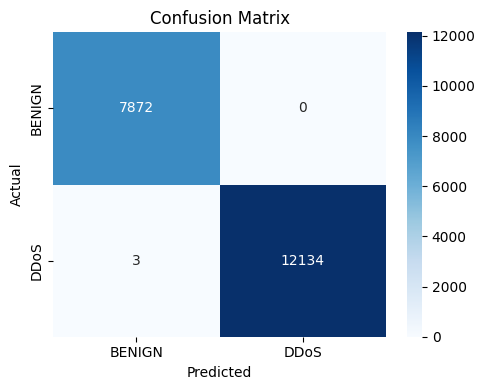

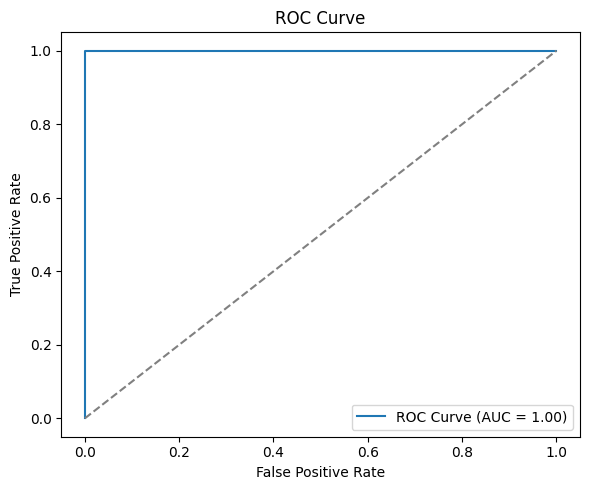

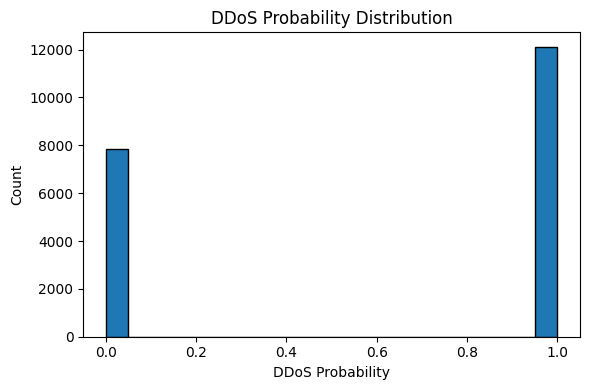

In [ ]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ---------- ROC CURVE ----------
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='DDoS')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor="black")
plt.title("DDoS Probability Distribution")
plt.xlabel("DDoS Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:

# Create a sample DataFrame matching the structure of X (features used for training)
# We'll use dummy values for demonstration, replace with actual sample data if available
sample = pd.DataFrame([{
    'Destination Port': 54865, 'Flow Duration': 3, 'Total Fwd Packets': 2,
    'Total Backward Packets': 0, 'Total Length of Fwd Packets': 12,
    'Total Length of Bwd Packets': 0, 'Fwd Packet Length Max': 6,
    'Fwd Packet Length Min': 6, 'Fwd Packet Length Mean': 6.0,
    'Fwd Packet Length Std': 0.0, 'Bwd Packet Length Max': 0,
    'Bwd Packet Length Min': 0, 'Bwd Packet Length Mean': 0.0,
    'Bwd Packet Length Std': 0.0, 'Flow Bytes/s': 0.0, # Will be imputed if NaN/inf
    'Flow Packets/s': 0.0, # Will be imputed if NaN/inf
    'Flow IAT Mean': 3.0, 'Flow IAT Std': 0.0, 'Flow IAT Max': 3,
    'Flow IAT Min': 3, 'Fwd IAT Total': 3, 'Fwd IAT Mean': 3.0,
    'Fwd IAT Std': 0.0, 'Fwd IAT Max': 3, 'Fwd IAT Min': 3,
    'Bwd IAT Total': 0, 'Bwd IAT Mean': 0.0, 'Bwd IAT Std': 0.0,
    'Bwd IAT Max': 0, 'Bwd IAT Min': 0, 'Fwd PSH Flags': 0,
    'Bwd PSH Flags': 0, 'Fwd URG Flags': 0, 'Bwd URG Flags': 0,
    'Fwd Header Length': 40, 'Bwd Header Length': 0, 'Fwd Packets/s': 0.0, # Will be imputed if NaN/inf
    'Bwd Packets/s': 0.0, 'Min Packet Length': 6, 'Max Packet Length': 6,
    'Packet Length Mean': 6.0, 'Packet Length Std': 0.0,
    'Packet Length Variance': 0.0, 'FIN Flag Count': 0, 'SYN Flag Count': 0,
    'RST Flag Count': 0, 'PSH Flag Count': 0, 'ACK Flag Count': 0,
    'URG Flag Count': 0, 'CWE Flag Count': 0, 'ECE Flag Count': 0,
    'Down/Up Ratio': 0, 'Average Packet Size': 9.0, 'Avg Fwd Segment Size': 6.0,
    'Avg Bwd Segment Size': 0.0, 'Fwd Header Length.1': 40,
    'Fwd Avg Bytes/Bulk': 0, 'Fwd Avg Packets/Bulk': 0,
    'Fwd Avg Bulk Rate': 0, 'Bwd Avg Bytes/Bulk': 0,
    'Bwd Avg Packets/Bulk': 0, 'Bwd Avg Bulk Rate': 0, 'Subflow Fwd Packets': 2,
    'Subflow Fwd Bytes': 12, 'Subflow Bwd Packets': 0, 'Subflow Bwd Bytes': 0,
    'Init_Win_bytes_forward': -1, 'Init_Win_bytes_backward': -1,
    'act_data_pkt_fwd': 1, 'min_seg_size_forward': 20, 'Active Mean': 0.0,
    'Active Std': 0.0, 'Active Max': 0, 'Active Min': 0, 'Idle Mean': 0.0,
    'Idle Std': 0.0, 'Idle Max': 0, 'Idle Min': 0
}])

pred = model.predict(sample)[0]
prob = model.predict_proba(sample)[0][list(model.classes_).index('DDoS')]

print("\n=== SAMPLE PREDICTION ===")
print("Prediction (Label):", pred)
print("DDoS Probability:", prob)



=== SAMPLE PREDICTION ===
Prediction (Label): BENIGN
DDoS Probability: 0.06
